# dotto

> A workspace for a directed graph based approach to the Colonel Blotto game, named Colonel Dotto.

In [1]:
#| default_exp dotto

I was struck by a moment of inspiration at around 1:30am on Tuesday 10/11/22. I want to hark back to something Professor Haddock told me during my exploration of the Colonel Blotto problem during the fall semester of my freshman year, which was to have fun with the research question and ask fundamental questions. These were questions such as given a strategy is there always a minimal change to "improve" a strategy. This can be represented in a directed graph by having the allocations to  the castle in a game be represented as a tuple; this tuple will be used as the graph weights for the graphs nodes. Each graph node will represent an individual strategy for the game. I was initially considering the edges to be unweighted because the weighted context did not arise naturally until now. That being, let the weight of an edge from one node to it's dominating node be $\sum\limits_{i=1}^{\text{\# of castles}}v_i * ?t_i$, where $v_i$ is the value of the $i$ th castle (which could possibly be weighted by how many extra troops the dominating strategy won by at that castle).

I returned to this on 11/30/22. Let's do some damage, using graphs!

In [2]:
import networkx as nx
import matplotlib.pyplot as plt


def preprocess_document(document, sentence_spliter='.', word_spliter=' ', punct_mark=','):
    # lowercase all words and remove trailing whitespaces
    document = document.lower().strip()
    
    # remove unwanted punctuation marks
    for pm in punct_mark:
        document = document.replace(pm, '')
    
    # get list of sentences which are non-empty
    sentences = [sent for sent in document.split(sentence_spliter) if sent != '']
    
    # get list of sentences which are lists of words
    document = []
    for sent in sentences:
        words = sent.strip().split(word_spliter)
        document.append(words)
        
    return document

def get_entities(document):
    # in our case, entities are all unique words
    unique_words = []
    for sent in document:
        for word in sent:
            if word not in unique_words:
                unique_words.append(word)
    return unique_words

def get_relations(document):
    # in our case, relations are bigrams in sentences
    bigrams = []
    for sent in document:
        for i in range(len(sent)-1):
            # for every word and the next in the sentence
            pair = [sent[i], sent[i+1]]
            # only add unique bigrams
            if pair not in bigrams:
                bigrams.append(pair)
    return bigrams

def build_graph(doc):
    # preprocess document for standardization
    pdoc = preprocess_document(doc)
    
    # get graph nodes
    nodes = get_entities(pdoc)
    
    # get graph edges
    edges = get_relations(pdoc)
    
    # create graph structure with NetworkX
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

def build_digraph(doc):
    # preprocess document for standardization
    pdoc = preprocess_document(doc)
    
    # get graph nodes
    nodes = get_entities(pdoc)
    
    # get graph edges
    edges = get_relations(pdoc)
    
    # create graph structure with NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

def get_weighted_edges(document):
    # in our case, relations are bigrams in sentences
    # weights are number of equal bigrams
    # use a dict to store number of counts
    bigrams = {}
    for sent in document:
        for i in range(len(sent)-1):
        
            # transform to hashable key in dict
            pair = str([sent[i], sent[i+1]])
            
            if pair not in bigrams.keys():
                # weight = 1
                bigrams[pair] = 1
            else:
                # already exists, weight + 1
                bigrams[pair] += 1
                
    # convert to NetworkX standard form each edge connecting nodes u and v = [u, v, weight]
    weighted_edges_format = []
    for pair, weight in bigrams.items():
        # revert back from hashable format
        w1, w2 = eval(pair)
        weighted_edges_format.append([w1, w2, weight])
        
    return weighted_edges_format

def build_weighted_digraph(document):
    # preprocess document for standardization
    pdoc = preprocess_document(document)
    
    # get graph nodes
    nodes = get_entities(pdoc)
    
    # get weighted edges
    weighted_edges = get_weighted_edges(pdoc)
    
    # create graph structure with NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges)
    
    return G

def plot_graph(G, title=None):
    # set figure size
    plt.figure(figsize=(10,10))
    
    # define position of nodes in figure
    pos = nx.nx_agraph.graphviz_layout(G)

    # draw nodes and edges
    nx.draw_networkx(G, pos=pos, ax=None, with_labels=True)
    
    # get edge labels (if any)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # draw edge labels (if any)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # plot the title (if any)
    plt.title(title)
    
    plt.show()
    return


Bad key "text.kerning_factor" on line 4 in
/gpfs/ysm/project/sumry2022/sumry2022_ta483/conda_envs/dotto/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
flowers_of_evil = '''Come, lie upon my breast, cruel, insensitive soul,
Adored tigress, monster with the indolent air
I want to plunge trembling fingers for a long time
In the thickness of your heavy mane,

To bury my head, full of pain 
In your skirts redolent of your perfume, 
To inhale, as from a withered flower, 
The moldy sweetness of my defunct love.

I wish to sleep. to sleep rather than live. 
In a slumber doubtful as death, 
I shall remorselessly cover with my kisses 
Your lovely body polished like copper.

To bury my subdued sobbing 
Nothing equals the abyss of your bed, 
Potent oblivion dwells upon your lips 
And Lethe flows in your kisses.

My fate, hereafter my delight, 
I'll obey like one predestined 
Docile martyr, innocent man condemned, 
Whose fervor aggravates the punishment.

I shall suck, to drown my rancor, 
Nepenthe and the good hemlock 
From the charming tips of those pointed breasts 
That have never guarded a heart.'''

eye_glasses = 'A color in shaving, a saloon is well placed in the centre of an alley.'

example = "The person arrived. They sat down."
document = eye_glasses
g = build_graph(document)
dig = build_digraph(document)
wdig = build_weighted_digraph(document)

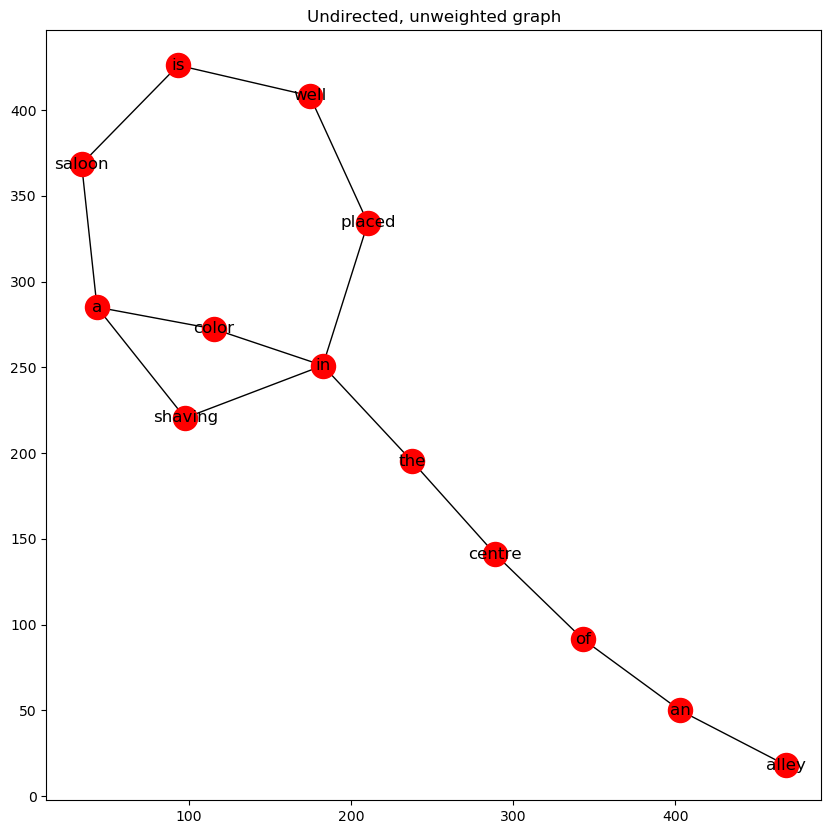

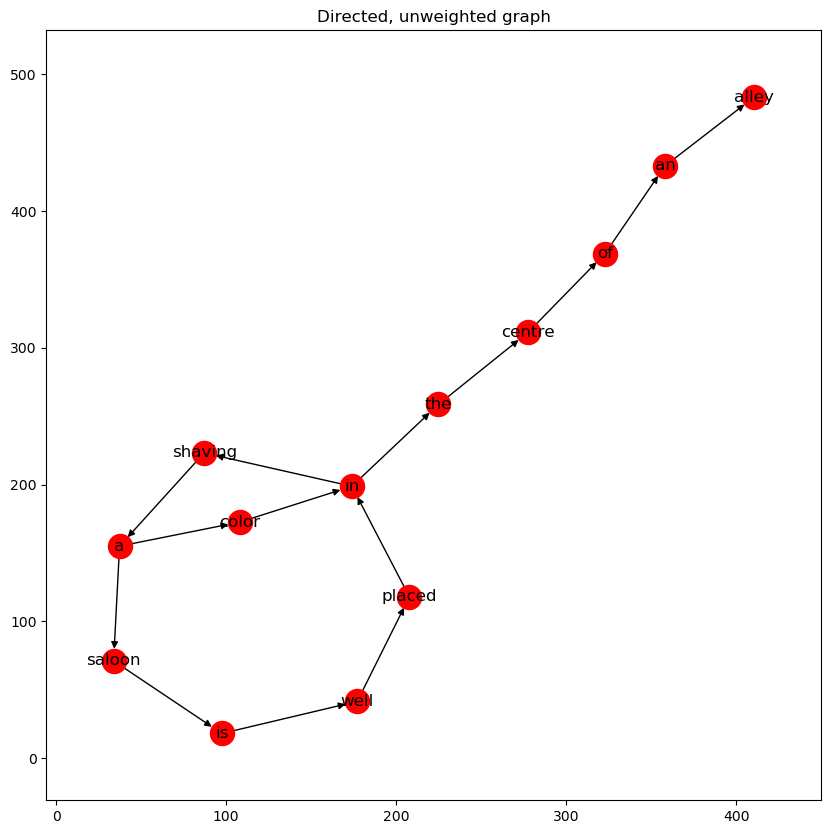

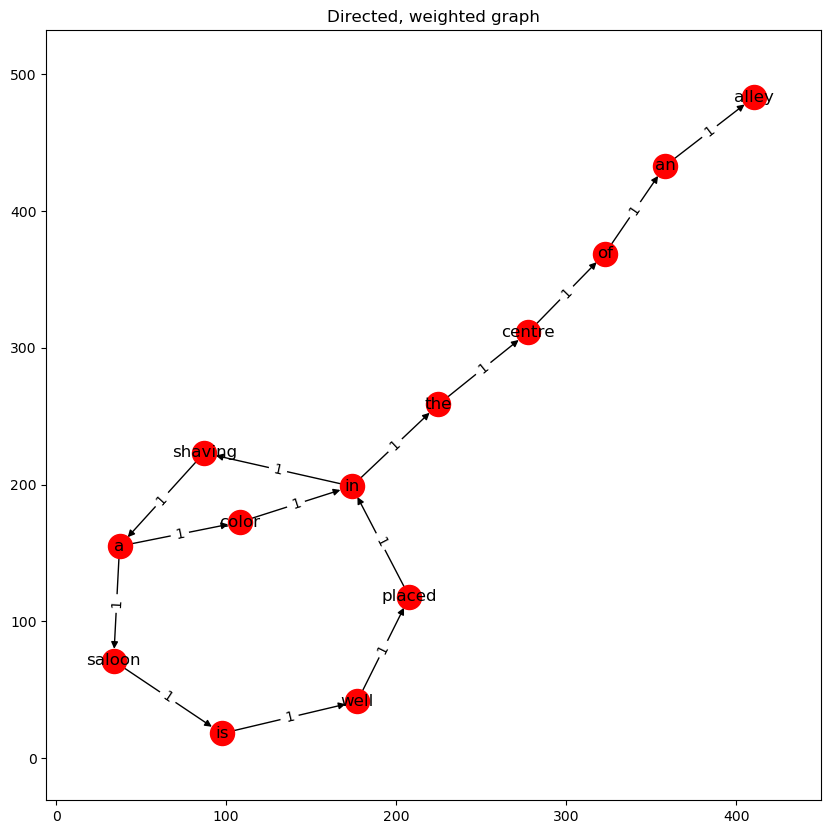

In [4]:
plot_graph(g, "Undirected, unweighted graph")
plot_graph(dig, "Directed, unweighted graph")
plot_graph(wdig, "Directed, weighted graph")

In [5]:
# can be any type of centrality
node_scores = nx.betweenness_centrality(g)

# from highest to lowest (hence the negative sign)
sorted_node_scores = dict(sorted(node_scores.items(), key=lambda item: -item[1]))
print(sorted_node_scores)
# get words corresponding to nodes (in scoring order)
sorted_nodes = list(sorted_node_scores.keys())

# candidate KW = highest scoring nodes (1/3 of all nodes)
candidate_kw = sorted_nodes[:int(len(sorted_nodes)/3)]

{'in': 0.6136363636363636, 'the': 0.48484848484848486, 'centre': 0.4090909090909091, 'of': 0.30303030303030304, 'placed': 0.21212121212121213, 'an': 0.16666666666666669, 'a': 0.1590909090909091, 'well': 0.12121212121212122, 'color': 0.09848484848484848, 'shaving': 0.09848484848484848, 'saloon': 0.06060606060606061, 'is': 0.045454545454545456, 'alley': 0.0}


In [6]:
import spacy
from spacy.tokens import Token
import nltk

def transform_uni_to_ngram(unigram_keywords, text):
    """
  Candidate unigrams that form ngrams in the text
  are merged and now form a single candidate keyphrase.
  """
  # set the spacy model
    nlp = spacy.load("en_core_web_sm")

  # function that tells if spacy token is keyword or not
    ckw_getter = lambda token: token.text.lower() in unigram_keywords
  
  # set that function as token extension (as attribute with ._)
    Token.set_extension("is_ckw", getter=ckw_getter, force=True)

  # variable to store resulting keyphrases
    res = []
  
  # split original text in sentences
    sentences = nltk.sent_tokenize(text)
  
    for sent in sentences:
      # start keyphrase as empty string
      merged_tokens = ''
      
      # process sentence with spacy model defined beforehand
    sent = nlp(sent)
      
    for token in sent:
          # if token is candidate KW (according to func defined before)
        if token._.is_ckw:
          
              # add it to keyphrase
              merged_tokens += token.text.lower() + ' '
         
         # means that sequence of tokens in text that are candidate KW ends
        else:
              # check if keyphrase not empty and already not in list of results
                if merged_tokens != '' and merged_tokens.strip() not in res:
                  
                  # only add keyphrases for now, no unigrams
                    if len(merged_tokens.strip().split(' ')) != 1:
                        res.append(merged_tokens.strip())
                  
                  # set keyphrase as empty string again
                    merged_tokens = ''


    for uni in unigram_keywords:
          # only add unigram KW to results list if not there already
        if uni not in res:

            add_uni = True

            for other in res:  
                  # only add unigram KW to results list if not used in keyphrase somewhere
                    if uni in other:
                        add_uni = False

            if add_uni:
                res.append(uni)   
  
    return res

In [7]:
transform_uni_to_ngram(candidate_kw, eye_glasses)

['in the centre of']

In [8]:
from node2vec import Node2Vec
node2vec = Node2Vec(g, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

/gpfs/ysm/project/sumry2022/sumry2022_ta483/conda_envs/dotto/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating walks (CPU: 3): 100%|██████████| 50/50 [00:04<00:00, 12.49it/s]

In [9]:
# Look for most similar nodes
model.wv.most_similar('centre')

[('of', 0.8744595646858215),
 ('the', 0.7901211380958557),
 ('an', 0.7885516285896301),
 ('alley', 0.7553330063819885),
 ('in', 0.47600799798965454),
 ('color', 0.32520419359207153),
 ('shaving', 0.26742956042289734),
 ('placed', 0.22931842505931854),
 ('well', 0.2011890858411789),
 ('a', 0.1579960584640503)]

In [10]:
emb=model.wv[[i for i in model.wv.key_to_index]]
emb.shape

(13, 64)

{'in': 0,
 'a': 1,
 'an': 2,
 'of': 3,
 'centre': 4,
 'the': 5,
 'is': 6,
 'well': 7,
 'shaving': 8,
 'placed': 9,
 'color': 10,
 'saloon': 11,
 'alley': 12}

In [34]:
from sklearn.decomposition import PCA
def plot_embeddings(emb, num_nodes, title=""):
    if emb.shape[1] > 2:
        pca = PCA(n_components=2)
        emb= pca.fit_transform(emb)
    plt.figure()
    plt.figure()
    sc = plt.scatter(emb[:,0],emb[:,1])
    for i, label in enumerate(sorted_nodes):
        plt.annotate(label, (emb[:,0][i], emb[:,1][i]))
    plt.suptitle(title)
    plt.show()

<Figure size 640x480 with 0 Axes>

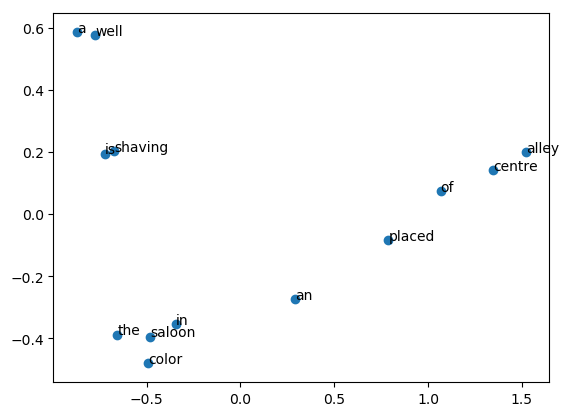

In [35]:
plot_embeddings(emb, len(sorted_node_scores))

Colonel Blotto below.

In [ ]:


import csv
import itertools

def sums(length, total_sum):
    if length == 1:
        yield (total_sum,)
    else:
        for value in range(total_sum + 1):
            for permutation in sums(length - 1, total_sum - value):
                yield (value,) + permutation

def game(player1, player2, numCastles):
    p1_score = 0
    p2_score = 0
    n = 0
    p1_wbt = 0
    p2_wbt = 0

    while p1_wbt < 3 and p2_wbt < 3 and n < numCastles:
        if player1[n] > player2[n]:
            p1_score += n + 1
            p1_wbt += 1
            p2_wbt = 0
        if player1[n] < player2[n]:
            p2_score += n + 1
            p2_wbt += 1
            p1_wbt = 0
        if player1[n] == player2[n]:
            p1_wbt = 0
            p2_wbt = 0
        n += 1

    while p1_wbt == 3 and n < numCastles:
        p1_score += n + 1
        n += 1
    while p2_wbt == 3 and n < numCastles:
        p2_score += n + 1
        n += 1

    if p1_score > p2_score:
        return 1
    if p1_score < p2_score:
        return -1
    if p1_score == p2_score:
        return 0
    
def tournament(numTroops, numCastles):
    strategies = list(sums(numCastles, numTroops))
    competitors = {}
    for allocation in strategies:
        competitors[allocation] = [0, 0, 0]
    file_data = []
    highest_score = 0
    gameMatrix = [[0 for i in range(len(strategies))] for j in range(len(strategies))]
    for i, player1 in enumerate(competitors):
        for j, player2 in enumerate(competitors):
            result = game(player1, player2, numCastles)
            gameMatrix[i][j] = result
            if result == 1:
                competitors[player1][0] += 1
                competitors[player2][1] += 1
            if result == -1:
                competitors[player2][0] += 1
                competitors[player1][1] += 1
            else:
                competitors[player1][2] += 1
                competitors[player2][2] += 1
    file_data.append(competitors)
    file_data.append(gameMatrix)
    filename = f"C{numCastles:02}-T{numTroops:03}.txt"

    with open(filename, "w") as fle:
        json.dump(file_data, fle)

def csvtournament(numTroops, numCastles):
    strategies = list(sums(numCastles, numTroops))
    competitors = {}
    for allocation in strategies:
        competitors[allocation] = [0, 0, 0]
    winners = []
    highest_score = 0
    gameMatrix = [[0 for i in range(len(strategies))] for j in range(len(strategies))] 
    for i, player1 in enumerate(competitors):
        for j, player2 in enumerate(competitors):
            result = game(player1, player2, numCastles)
            gameMatrix[i][j] = result
            if result == 1:
                competitors[player1][0] += 1 # Player 1 win
                competitors[player2][1] += 1 # Player 2 loss
            if result == -1:
                competitors[player2][0] += 1 # Player 2 win
                competitors[player1][1] += 1 # Player 1 loss
            if result == 0:
                competitors[player1][2] += 1 # tie
                competitors[player1][2] += 1 # tie
    all_scores = competitors.values()
    highest_score = max(all_scores)
    for player in competitors:
        if competitors[player] == highest_score:
            winners.append(player)
    print(gameMatrix)

    fields = ["win_percentile"]
    for i in range(1, numCastles + 1):
        fields.append("c" + str(i))
    rows = []
    for strategy in competitors:
        profile = [(competitors[strategy][0]/competitors[strategy][0] + competitors[strategy][1] + competitors[strategy][2])]
        for troops in strategy:
            profile.append(troops)
        rows.append(profile)
    filename = 'csvBlotto, numCastles = ' + str(numCastles) + ", numTroops =" + str(numTroops)

# writing to csv file
    with open(filename, 'w') as csvfile:
    # creating a csv writer object
        csvwriter = csv.writer(csvfile)

    # writing the fields
        csvwriter.writerow(fields)

    # writing the data rows
        csvwriter.writerows(rows)

def dottocsv(numTroops, numCastles):
    strategies = list(sums(numCastles, numTroops))
    edgelist = []

    unique = list(itertools.combinations(range(len(strategies)), r=2))
    
    for pair in unique:
        i = pair[0]
        j = pair[1]
        player1 = strategies[i]
        player2 = strategies[j]
    
        result = game(player1, player2, numCastles)

        if result == 1:
        # Player 1 win, Player 2 loss
            edge = (j, i)
            edgelist.append(edge)
        if result == -1:
        # Player 2 win, Player 1 loss
            edge = (i, j)
            edgelist.append(edge)
        #if result == 0:
        # Tie
 

    filename = f'T{numTroops}C{numCastles}'

    f = open(filename, 'w')
    f.write(str(edgelist))
    f.close()


In [72]:
dottocsv(2, 3)

In [73]:
import ast

f = open("./T2C3", 'r')
edgelist = ast.literal_eval(f.readline())

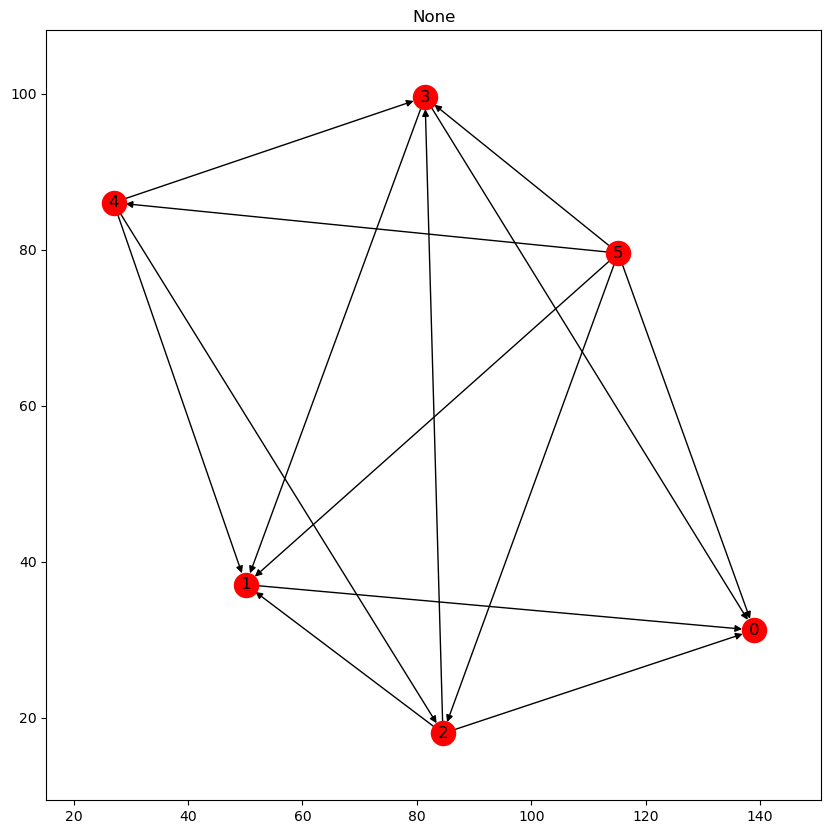

[[0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 0 1 0 0]
 [1 1 0 0 0 0]
 [1 1 1 1 0 1]
 [1 0 1 1 0 0]]


In [76]:
Graphtype = nx.DiGraph() 
Graph =  nx.from_edgelist(edgelist, create_using=Graphtype)
plot_graph(Graph)
A = nx.adjacency_matrix(Graph)
print(A.todense())